In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [3]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [4]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 25

## Data preparation

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, let's load up the
[DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped






# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
29084464/29084464 [==============================] - 0s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

In [6]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [7]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [8]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask


Now, we can create a subclassed layer for the Transformer.

In [9]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [10]:

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## Model training and inference

In [11]:
trained_model = run_experiment()

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 1.7801 - accuracy: 0.6429
Epoch 1: val_loss improved from inf to 0.48474, saving model to /tmp/video_classifier
16/16 [==============================] - 11s 560ms/step - loss: 1.7801 - accuracy: 0.6429 - val_loss: 0.4847 - val_accuracy: 0.8556
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9444
Epoch 2: val_loss did not improve from 0.48474
16/16 [==============================] - 8s 507ms/step - loss: 0.1680 - accuracy: 0.9444 - val_loss: 1.8348 - val_accuracy: 0.5222
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9841
Epoch 3: val_loss did not improve from 0.48474
16/16 [==============================] - 8s 483ms/step - loss: 0.0451 - accuracy: 0.9841 - val_loss: 0.6446 - val_accuracy: 0.8556
Epoch 4/25
16/16 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9921
Epoch 4: val_loss did not improve from 0.48474
16/

**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: v_Punch_g06_c02.avi
1/1 [==============================] - 0s 42ms/step
  Punch: 100.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%



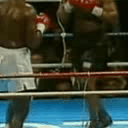

In [13]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
import math

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

# feedforward

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

# attention

def attn(q, k, v):
    sim = einsum('b i d, b j d -> b i j', q, k)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.,
        num_tokens = 1,
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        
        self.num_tokens = num_tokens

    def forward(self, x, einops_from, einops_to, **einops_dims):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        q *= self.scale

        # splitting out added target tokens
        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, 0:self.num_tokens], t[:, self.num_tokens:]), (q, k, v))

        # target tokens attend all the tokens in sequence
        cls_out = attn(cls_q, k, v)

        # rearrange across time or space
        # 'b (f n) d' -> '(b n) f d'
        # 'b (f n) d' -> '(b f) n d'
        # time = batch, frame * num token, dim -> batch * num patch, frame, dim -> iters frame
        # space = batch, frame * num token, dim -> batch * num frame, patch, dim -> iters patch
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        # expand cls token keys and values across time or space and concat
        r = q_.shape[0] // cls_k.shape[0]

        cls_k, cls_v = map(lambda t: repeat(t, 'b t d -> (b r) t d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)

        # attention
        out = attn(q_, k_, v_)

        # merge back time or space
        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)

        # concat back the cls token
        out = torch.cat((cls_out, out), dim = 1)

        # merge back the heads
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)

        # combine heads out
        return self.to_out(out)

# main classes

class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_target_frames = 4,
        image_size = 224,
        patch_size = 16,
        channels = 3,
        out_channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.,
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        self.dim = dim
        self.out_channels = out_channels

        num_patches = (image_size // patch_size) ** 2
        num_positions = num_frames * num_patches
        patch_dim = channels * patch_size ** 2
        out_patch_dim = out_channels * patch_size ** 2

        self.num_tokens = num_target_frames
        self.num_target_patches = self.num_tokens * num_patches

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)

        # extend positional embedding, define the target tokens
        self.pos_emb = nn.Embedding(num_positions + self.num_target_patches, dim)
        self.target_tokens = nn.Parameter(torch.randn(self.num_target_patches, dim))

        self.layers = nn.ModuleList([])
        for _ in range(depth):

            # time_attn, space_attn, ff
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout, num_tokens = self.num_target_patches)),
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout, num_tokens = self.num_target_patches)),
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout))
            ]))

        self.to_dembedded_out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_patch_dim)
        )

    def forward(self, video):
        b, f, _, h, w, *_, device, p = *video.shape, video.device, self.patch_size
        assert h % p == 0 and w % p == 0, f'height {h} and width {w} of video must be divisible by the patch size {p}'

        n = (h // p) * (w // p)
        
        video = rearrange(video, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p, p2 = p)

        # from patch size to embedding size
        tokens = self.to_patch_embedding(video)

        target_tokens = repeat(self.target_tokens, 'n d -> b n d', b = b)
        x =  torch.cat((target_tokens, tokens), dim = 1) 
        x += self.pos_emb(torch.arange(x.shape[1], device = device))

        for (time_attn, spatial_attn, ff) in self.layers:
            x = time_attn(x, 'b (f n) d', '(b n) f d', n = n) + x # 1 patch over N frames
            x = spatial_attn(x, 'b (f n) d', '(b f) n d', f = f) + x # N patches for 1 frame
            x = ff(x) + x
            break

        # out_tokens <- num_target_frames * num_patches
        out_tokens = x[:, 0:self.num_target_patches]

        # embed dim -> original patch dim
        out_tokens = self.to_dembedded_out(out_tokens)

        return out_tokens.view(b, self.num_tokens, self.out_channels, h, w)

The performance of our model is far from optimal, because it was trained on a
small dataset.